In [1]:
import caffe
import lmdb
import os
import caffe.proto.caffe_pb2
from caffe.io import datum_to_array
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import distance

In [2]:
def read_from_db(db_dir):
    lmdb_env = lmdb.open(db_dir)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    datum = caffe.proto.caffe_pb2.Datum()

    D = []

    for idx, (key, value) in enumerate(lmdb_cursor):
        datum.ParseFromString(value)
        data = caffe.io.datum_to_array(datum)
        D.append(data.flatten())

    lmdb_env.close()
    return D

In [3]:
def read_labels(label_file):
    D = []
    with open(label_file,'rb') as f:
        for line in f:
            D.append(int(line.split(' ')[1]))
    return D

In [4]:
X_train = read_from_db('/Users/ecsark/Documents/visualdb/project/wikiart/train_vgg_feature_fc6')
y_train = read_labels('/Users/ecsark/Documents/visualdb/project/wikiart/train.txt')
X_test = read_from_db('/Users/ecsark/Documents/visualdb/project/wikiart/test_vgg_feature_fc6')
y_test = read_labels('/Users/ecsark/Documents/visualdb/project/wikiart/test.txt')

In [5]:
label_names = []
with open("/Users/ecsark/Documents/visualdb/project/artwork-explorer/data/label.txt", 'rb') as f:
    for line in f:
        tokens = line.split(" ")[1:]
        label_names.append(" ".join(tokens))

In [6]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
y_pred = clf.predict(X_test)
error = sum([1 if p!=g else 0 for (p, g) in zip(y_pred, y_test)])
print 1.0 - 1.0*error/len(y_test)

0.209


In [8]:
print list(y_pred[:20])
print list(y_test[:20])

[8, 8, 8, 8, 4, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8]
[2, 2, 7, 5, 4, 6, 4, 8, 6, 8, 5, 3, 0, 4, 0, 4, 3, 7, 5, 4]


Confusion matrix, without normalization
[[ 20   3   8   0   0   2   0   2 157   8]
 [  1  30   7   1   2   0   4   4 150   1]
 [  4   1  20   1   0   5   3   1 156   9]
 [  3   0  10  31   2  10   9   1 127   7]
 [  3   1   4   1  41   0   2   2 146   0]
 [ 10   1  14  12   1  15   8   0 132   7]
 [  1  10   8  17   5   2  28   8 117   4]
 [  2  10   7   5   4   0  18  25 125   4]
 [  4   3   2   0   1   0   1   0 186   3]
 [  7   3   7   3   1   3   5   3 146  22]]
Normalized confusion matrix
[[ 0.1   0.01  0.04  0.    0.    0.01  0.    0.01  0.79  0.04]
 [ 0.01  0.15  0.04  0.01  0.01  0.    0.02  0.02  0.75  0.01]
 [ 0.02  0.01  0.1   0.01  0.    0.03  0.01  0.01  0.78  0.04]
 [ 0.01  0.    0.05  0.15  0.01  0.05  0.04  0.01  0.64  0.04]
 [ 0.01  0.01  0.02  0.01  0.2   0.    0.01  0.01  0.73  0.  ]
 [ 0.05  0.01  0.07  0.06  0.01  0.07  0.04  0.    0.66  0.04]
 [ 0.01  0.05  0.04  0.09  0.03  0.01  0.14  0.04  0.58  0.02]
 [ 0.01  0.05  0.04  0.03  0.02  0.    0.09  0.12  0.62  0.0

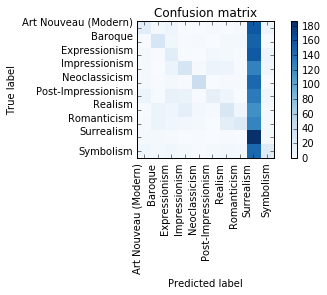

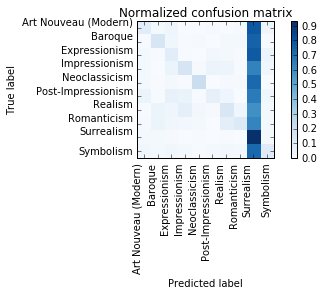

In [9]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=90)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [10]:
def findMostSimilar(X, x_query, k=5):
    dist = distance.cdist(X, np.array([x_query]), 'euclidean')
    return dist.flatten().argsort()[:k]

In [11]:
k_min_idx = findMostSimilar(X_train, X_test[4], 10)
print k_min_idx
print [y_train[i] for i in k_min_idx]

[5474 5900 3636 7146 1290 2119 3068 3725  129 1270]
[4, 1, 1, 4, 1, 1, 1, 1, 5, 1]


In [12]:
for i in range(20):
    k_min_idx = findMostSimilar(X_train, X_test[i], 10)
    labels = [y_train[j] for j in k_min_idx]
    print y_test[i], max(set(labels), key=labels.count), labels

2 1 [1, 2, 9, 6, 1, 1, 1, 7, 7, 0]
2 2 [5, 2, 2, 2, 5, 2, 2, 6, 4, 7]
7 1 [2, 7, 7, 6, 3, 8, 1, 6, 1, 4]
5 6 [3, 9, 3, 3, 6, 6, 5, 6, 7, 6]
4 1 [4, 1, 1, 4, 1, 1, 1, 1, 5, 1]
6 1 [1, 1, 1, 1, 4, 7, 7, 6, 6, 1]
4 4 [4, 4, 4, 4, 6, 5, 4, 4, 4, 4]
8 2 [7, 8, 9, 4, 2, 8, 0, 2, 2, 8]
6 0 [5, 7, 3, 1, 0, 5, 0, 9, 6, 6]
8 1 [5, 6, 2, 9, 6, 1, 1, 2, 9, 1]
5 3 [5, 5, 3, 3, 3, 3, 3, 3, 3, 9]
3 5 [5, 3, 3, 5, 5, 3, 5, 2, 9, 9]
0 1 [1, 0, 2, 1, 5, 1, 0, 1, 1, 3]
4 4 [4, 8, 4, 0, 1, 8, 4, 9, 1, 1]
0 2 [6, 1, 2, 5, 2, 4, 2, 9, 5, 7]
4 4 [4, 5, 4, 2, 4, 4, 0, 2, 3, 3]
3 5 [3, 5, 5, 9, 6, 3, 5, 2, 5, 3]
7 1 [7, 9, 9, 2, 1, 2, 3, 1, 1, 3]
5 5 [5, 5, 5, 5, 5, 0, 0, 2, 5, 3]
4 9 [0, 6, 2, 9, 9, 1, 4, 1, 4, 9]


In [13]:
y_pred_max = []

for x in X_test:
    k_min_idx = findMostSimilar(X_train, x, 10)
    labels = [y_train[i] for i in k_min_idx]
    y_pred_max.append(max(set(labels), key=labels.count))

error_max = sum([1 if p!=g else 0 for (p, g) in zip(y_pred_max, y_test)])
print 1.0 - 1.0*error_max/len(y_pred_max)

0.305
